## Movie Recommender System - Item Based Collaborative Filtering

I will be using the Movie Lens data in this notebook to create a simple item based collaborative filtering system. 
Firstly, I will perform some exploratory data analysis on the dataset. 

The files that will be used in this project are available [here](https://grouplens.org/datasets/movielens/100k/).

We will be using 3 files:
1. Dataset containing movie ratings (u.data)
2. Dataset containing movie details (u.item)
3. Dataset containing user data (u.user)

So let's begin!

### Getting the Data

In [655]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [656]:
# Create movie ratings dataframe

r_cols = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, usecols=range(3), encoding="ISO-8859-1")

ratings.shape

(100003, 3)

In [657]:
ratings.tail()

,user_id,movie_id,rating
99998,880,476,3
99999,716,204,5
100000,276,1090,1
100001,13,225,2
100002,12,203,3


In [658]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 3 columns):
user_id     100003 non-null int64
movie_id    100003 non-null int64
rating      100003 non-null int64
dtypes: int64(3)
memory usage: 2.3 MB


There are 100003 movie rating by users. And the dataframe has a user_id, movie_id and the rating given by that particular user. There are no null values.

In [659]:
# Create movies dataframe

m_cols = ['movie_id', 'title' ,'release_date','video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv("ml-100k/u.item", sep='|', names=m_cols, encoding='latin-1')

movies.shape

(1682, 24)

In [660]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [661]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
movie_id              1682 non-null int64
title                 1682 non-null object
release_date          1681 non-null object
video_release_date    0 non-null float64
IMDb_URL              1679 non-null object
unknown               1682 non-null int64
Action                1682 non-null int64
Adventure             1682 non-null int64
Animation             1682 non-null int64
Children's            1682 non-null int64
Comedy                1682 non-null int64
Crime                 1682 non-null int64
Documentary           1682 non-null int64
Drama                 1682 non-null int64
Fantasy               1682 non-null int64
Film-Noir             1682 non-null int64
Horror                1682 non-null int64
Musical               1682 non-null int64
Mystery               1682 non-null int64
Romance               1682 non-null int64
Sci-Fi                1682 non-null int64
Thriller 

There are 1682 movies with a unique movie_id, title, release date and 19 genres. We will delete the columns. 

In [662]:
movies.drop(['video_release_date', 'IMDb_URL'], axis=1, inplace=True)

In [663]:
# Create users dataframe

u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip']
users = pd.read_csv("ml-100k/u.user", sep='|', names=u_cols, encoding="ISO-8859-1")

users.shape

(943, 5)

In [664]:
users.tail()

,user_id,age,gender,occupation,zip
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209
942,943,22,M,student,77841


In [665]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
gender        943 non-null object
occupation    943 non-null object
zip           943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


There are 943 unique users with age, gender and occupation details. We will delete the zip column. 

In [666]:
users.drop(['zip'], axis=1, inplace=True)

### Data Visualization

Let's check out the date in further details and do some data visualizations.

In [667]:
# Let's restructure the data a little better to we can visualize it better 

movieRatings = pd.merge(movies, ratings)

In [668]:
movieRatings.head()

,movie_id,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id,rating
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,308,4
1,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,287,5
2,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,148,4
3,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,280,4
4,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,66,3


Ok, this is much better. Let's check the ratings data a bit further into details next.
As we can see from the table above, we can have multiple entries for each model based on the number of user reviews. Let's review the top rated movies. 

In [669]:
# Quick look at the ratings data

movieRatings['rating'].describe()

count    100003.000000
mean          3.529864
std           1.125704
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [670]:
# Get means for each movie by using the groupby method

movieRatings.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Marlene Dietrich: Shadow and Light (1996)            5.0
Prefontaine (1997)                                   5.0
Santa with Muscles (1996)                            5.0
Star Kid (1997)                                      5.0
Someone Else's America (1995)                        5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Saint of Fort Washington, The (1993)                 5.0
Great Day in Harlem, A (1994)                        5.0
They Made Me a Criminal (1939)                       5.0
Aiqing wansui (1994)                                 5.0
Name: rating, dtype: float64

Ok, something does seem fishy here. Being a big movie buff most of these top rated movies are unknown to me. These clearly cannot be the top rated movies - we will have to check the total number of reviews of these movies. 

In [671]:
# Check the total number of reviews for Marlene Dietrich: Shadow and Light (1996)

movieRatings.loc[movieRatings['title'] == 'Marlene Dietrich: Shadow and Light (1996) ']
#movieRatings.loc[movieRatings['title'] == 'Prefontaine (1997)']

,movie_id,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id,rating
97212,1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,90,5


There's only one review for the first film and only 3 for the 2nd film. Clearly this is not correct and cannot be the top rated movies.
Let's see the most reviewed movies.

In [672]:
# Most rated movies - top 10

movieRatings.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 584
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

This makes more sense. Let's see the average rating for Star Wars.

In [673]:
movieRatings.loc[movieRatings['title'] == 'Star Wars (1977)'].rating.mean()

4.359589041095891

Ok, this is much better. Let us make df with the total number of user ratings and average rating for each movie.

In [674]:
movieStats = movieRatings.groupby('title').agg({'rating': [np.size, np.mean]})
movieStats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

In [675]:
movieStats['rating'].sort_values(by='size', ascending=False).head(10)

,size,mean
title,,
Star Wars (1977),584,4.359589
Contact (1997),509,3.803536
Fargo (1996),508,4.155512
Return of the Jedi (1983),507,4.007890
Liar Liar (1997),485,3.156701
"English Patient, The (1996)",481,3.656965
Scream (1996),478,3.441423
Toy Story (1995),452,3.878319
Air Force One (1997),431,3.631090


This is much better. It is clearly telling us what the average rating is and how many people rated. We will use this df later on with our filtering process. 

Let's create a few plots to see how the ratings are spread.

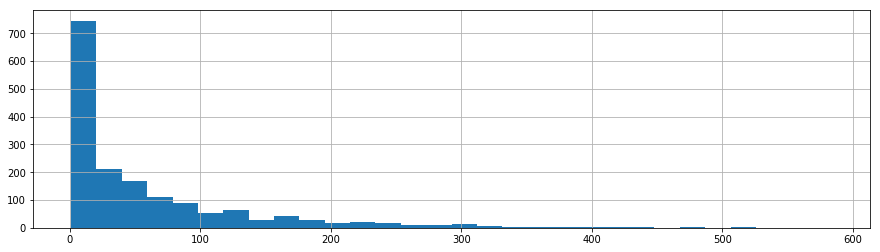

In [676]:
# Create histogram to see total number of ratings 

plt.figure(figsize=(15,4))
movieStats['rating']['size'].hist(bins=30)

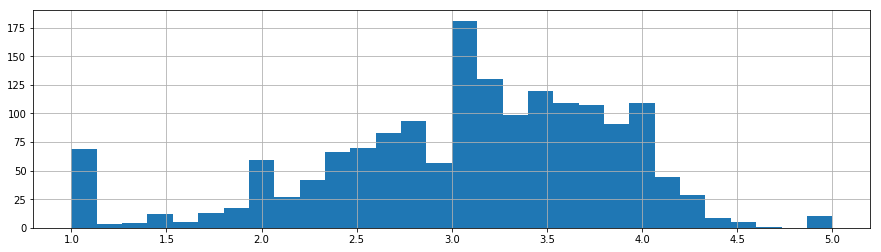

In [677]:
# Create histogram to see spread of ratings between 1 to 5

plt.figure(figsize=(15,4))
movieStats['rating']['mean'].hist(bins=30)

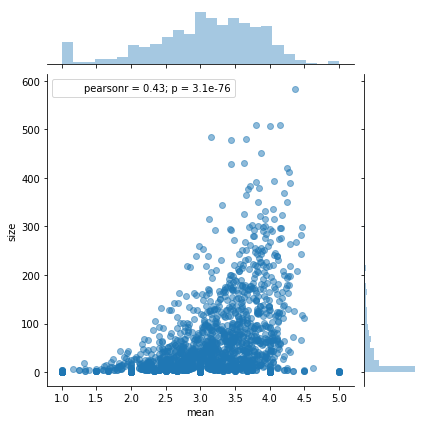

In [678]:
# Joinplot to show both number of ratings and rating

sns.jointplot(x='mean',y='size',data=movieStats['rating'],alpha=0.5)

This is giving us a good visualization of the spread of the ratings - looks like there are a lot of movies with a rating of around 3.

Let's now move onto to the genres now and take a quick visual tour of the data. 

Text(0.5,1,'Total number of Movies by Genre')

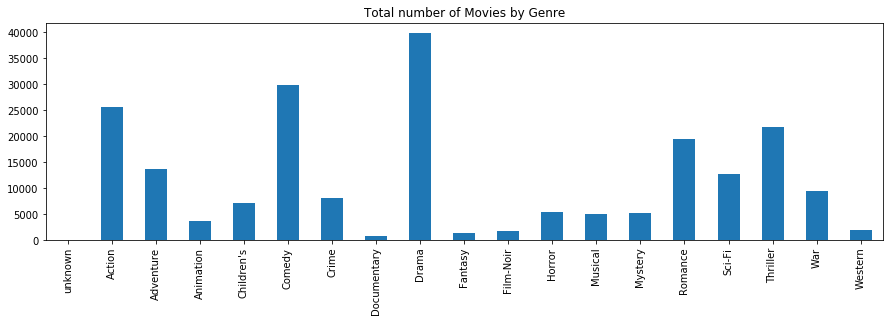

In [679]:
# Total of 19 genres 

genres = ['unknown', 'Action', 'Adventure','Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
counts = {}

# Create dictionary of genre : count
for i in genres:
    counts[i] = movieRatings[i].sum()

movieGenres = pd.DataFrame.from_dict(counts, orient='index')

# Plot the total number of movie in each genre

fig, ax= plt.subplots(figsize=(15,4))
movieGenres.plot(kind='bar', ax=ax, legend=False)
plt.title('Total number of Movies by Genre')

Looks like our data has the most Drama films, followed by Comedy, Action, Thriller and Romance. 
How are these genres spread across the years. Let's review that next. 

Text(0.5,1,'Total number of Movies by Genre over Years')

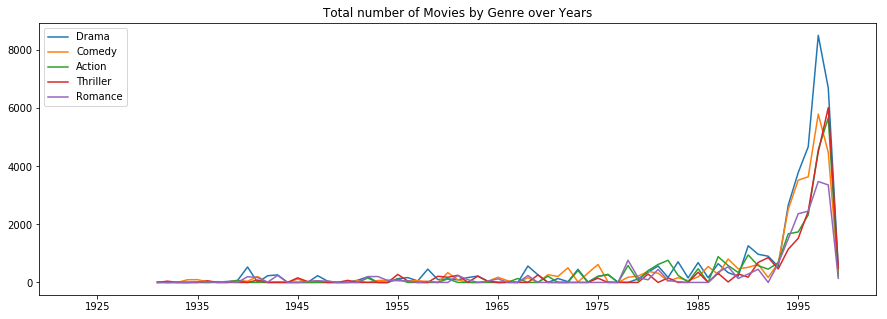

In [680]:
# Convert release_date to datetime and set as index

movieRatings['release_date'] = pd.to_datetime(movieRatings['release_date'])

movieRatings.index = movieRatings['release_date']


# Create plot for total number of Movies by Genre over Years

fig, ax= plt.subplots(figsize=(15,5))
plt.plot(movieRatings['Drama'].resample('A').sum())
plt.plot(movieRatings['Comedy'].resample('A').sum())
plt.plot(movieRatings['Action'].resample('A').sum())
plt.plot(movieRatings['Thriller'].resample('A').sum())
plt.plot(movieRatings['Romance'].resample('A').sum())
plt.legend()
plt.title('Total number of Movies by Genre over Years')


Ok, looks like our data has a gradual increase with a jump around the end of the 80s. 

This brings me to the end of visualizing the data. 
Now we can move on to creating the recommender system.

### Selecting Movies based on Similarity

The first step in building the system would be to figure out similar movies. 

We will create a matrix that has the user ids as rows and the movie titles as columns. Each column (movie) will have the rating given by the user (row) and where there are no ratings it will NaN (as every user hasn't rated all the movies).

In [681]:
# Create the matrix of users and movie ratings

movieMatrix = movieRatings.pivot_table(index=['user_id'],columns=['title'],values='rating')
movieMatrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will take 2 of the most rated movies out of top 10. We will go with Star Wars (584 ratings) and Toy Story (452 ratings). 

In [682]:
starWarsRatings = movieMatrix['Star Wars (1977)']
toyStoryRatings = movieMatrix['Toy Story (1995)']

Now we will get the similar movies to these two using the corrwith() method.
We will go through Star Wars first. 

In [683]:
# Create dataframe of similar movies and delete NaN

similarMoviesSW = movieMatrix.corrwith(starWarsRatings)
similarMoviesSW = similarMoviesSW.dropna()
dfSW = pd.DataFrame(similarMoviesSW)
dfSW.head(10)

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,0
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
"39 Steps, The (1935)",0.106453


In [684]:
# Let's see the movies with the highest correlation

similarMoviesSW.sort_values(ascending=False)

title
Hollow Reed (1996)                                                                   1.000000
Man of the Year (1995)                                                               1.000000
Star Wars (1977)                                                                     1.000000
Stripes (1981)                                                                       1.000000
Full Speed (1996)                                                                    1.000000
Golden Earrings (1947)                                                               1.000000
Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)    1.000000
Ed's Next Move (1996)                                                                1.000000
Scarlet Letter, The (1926)                                                           1.000000
Hurricane Streets (1998)                                                             1.000000
Safe Passage (1994)                                   

This result does not make sense! We are seeeing movies that are only seen by sme people who also happened to like star wars! So it is important here to have some sortof threshhold where there is minimum number of people who have rated. We have already created a dataframe before whihc can be used for this prupose precisely. Let's extract the popular movies which have been rated more than 300 times (arbitrary number).

In [685]:
popularMovies = movieStats['rating']['size'] >= 300
movieStats[popularMovies].sort_values([('rating', 'mean')], ascending=False)[:15]

rating          
                                            size      mean
title                                                     
Star Wars (1977)                             584  4.359589
Silence of the Lambs, The (1991)             390  4.289744
Godfather, The (1972)                        413  4.283293
Raiders of the Lost Ark (1981)               420  4.252381
Titanic (1997)                               350  4.245714
Empire Strikes Back, The (1980)              368  4.206522
Princess Bride, The (1987)                   324  4.172840
Fargo (1996)                                 508  4.155512
Monty Python and the Holy Grail (1974)       316  4.066456
Pulp Fiction (1994)                          394  4.060914
Fugitive, The (1993)                         336  4.044643
Return of the Jedi (1983)                    507  4.007890
Terminator, The (1984)                       301  3.933555
Indiana Jones and the Last Crusade (1989)    331  3.930514
Full Monty, The (1997)                       315  3.926984

Ok, this looks good. Let's join this data with our original set of similar movies to Star Wars:

In [686]:
dfSW = movieStats[popularMovies].join(pd.DataFrame(similarMoviesSW, columns=['similarity']))

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [687]:
dfSW.head()

,"(rating, size)","(rating, mean)",similarity
title,,,
Air Force One (1997),431,3.631090,0.113164
Back to the Future (1985),350,3.834286,0.274839
Chasing Amy (1997),379,3.839050,0.074536
Contact (1997),509,3.803536,0.134962
E.T. the Extra-Terrestrial (1982),300,3.833333,0.303619


In [688]:
# Sort by similarity score for top 5 movies (as Star Wars will be included we have taken top 6)

dfSW.sort_values(['similarity'], ascending=False)[:6]

,"(rating, size)","(rating, mean)",similarity
title,,,
Star Wars (1977),584,4.359589,1.000000
"Empire Strikes Back, The (1980)",368,4.206522,0.748353
Return of the Jedi (1983),507,4.007890,0.672556
Raiders of the Lost Ark (1981),420,4.252381,0.536117
Indiana Jones and the Last Crusade (1989),331,3.930514,0.350107
E.T. the Extra-Terrestrial (1982),300,3.833333,0.303619


This is pretty good! Top three form the original trilogy (including Star Wars). And the next three are Spielberg films and chances are pretty high that if you were a fan of George Lucas, you would have enjoyed the Spielberg movies too!

Let's now try the same with Toy Story and see how good are results are. 

In [689]:
# Create dataframe of similar movies and delete NaN

similarMoviesTS = movieMatrix.corrwith(toyStoryRatings)
similarMoviesTS = similarMoviesTS.dropna()
dfTS = pd.DataFrame(similarMoviesTS)
#dfTS.head(10)

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [690]:
dfTS = movieStats[popularMovies].join(pd.DataFrame(similarMoviesTS, columns=['similarity']))

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [691]:
dfTS.sort_values(['similarity'], ascending=False)[:6]

,"(rating, size)","(rating, mean)",similarity
title,,,
Toy Story (1995),452,3.878319,1.000000
Raiders of the Lost Ark (1981),420,4.252381,0.366414
E.T. the Extra-Terrestrial (1982),300,3.833333,0.365349
Indiana Jones and the Last Crusade (1989),331,3.930514,0.352870
Liar Liar (1997),485,3.156701,0.342576
Back to the Future (1985),350,3.834286,0.291803


Ok, this is not a very good result. This may be due to the fact that we are still using a threshold of 300 ratings for selecting the popular movies. This may not be applicable for Toy Story as fewr people may have rated it and we might be missing out on similar movies due to the high threshold. Let's remedy this and try a cutoff of 200 ratings. 

In [692]:
# All steps again only chnage the cutoff to 200

popularMovies = movieStats['rating']['size'] >= 200
dfTS = movieStats[popularMovies].join(pd.DataFrame(similarMoviesTS, columns=['similarity']))
dfTS.sort_values(['similarity'], ascending=False)[:6]

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(rating, size)","(rating, mean)",similarity
title,,,
Toy Story (1995),452,3.878319,1.000000
Beauty and the Beast (1991),202,3.792079,0.442960
"Lion King, The (1994)",220,3.781818,0.426778
Aladdin (1992),219,3.812785,0.411731
Top Gun (1986),220,3.481818,0.384972
Raiders of the Lost Ark (1981),420,4.252381,0.366414


This is much better. Looks like the top 3 (excluding Toy Story) as all animations, which is not a bad recommendation.

###  Item Based Collaborative Filtering

This is completed as part of a course on Udemy (Data Science, Deep Learning, & Machine Learning with Python - Sundog Education)

We will use the corr() method to calculate the correlation score for every column pair in the movieMatrix. 
Essentially we are getting the correlation between two movies where at least one user has rated both the movies. 

In [693]:
corrMatrix = movieMatrix.corr()
corrMatrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1.0,NaN,-1.000000,-0.500000,-0.500000,0.522233,NaN,-0.426401,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,1.0,NaN,NaN,NaN,NaN,NaN,-0.981981,NaN,NaN,...,NaN,NaN,NaN,-0.944911,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),-1.0,NaN,1.000000,-0.049890,0.269191,0.048973,0.266928,-0.043407,NaN,0.111111,...,NaN,-1.000000,NaN,0.158840,0.119234,0.680414,0.000000,0.707107,NaN,NaN
12 Angry Men (1957),-0.5,NaN,-0.049890,1.000000,0.666667,0.256625,0.274772,0.178848,NaN,0.457176,...,NaN,NaN,NaN,0.096546,0.068944,-0.361961,0.144338,1.000000,1.0,NaN
187 (1997),-0.5,NaN,0.269191,0.666667,1.000000,0.596644,NaN,-0.554700,NaN,1.000000,...,NaN,0.866025,NaN,0.455233,-0.500000,0.500000,0.475327,NaN,NaN,NaN


But we will restrict our results above to movies that lots of people have rated together - we'll use the min_periods argument to throw out results where fewer than 200 users rated a given movie pair:

In [748]:
corrMatrix = movieMatrix.corr(method='pearson', min_periods=200)
corrMatrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ok, this correlation matrix is now ready to be used for giving remomendations to specific users. Let's look at the first user as a test case as it only has three ratings - 2 distinct high ratings for star wars movies and 1 low rating for non sci-fi movie.

In [749]:
user1 = movieMatrix.loc[0].dropna()
user1

title
Empire Strikes Back, The (1980)    5.0
Gone with the Wind (1939)          1.0
Star Wars (1977)                   5.0
Name: 0, dtype: float64

In [753]:
simCandidates = pd.Series()
for i in range(0, len(user1.index)):
    print ("Adding sims for " + user1.index[i] + "...")
    # Retrieve similar movies to those rated by user1
    sims = corrMatrix[user1.index[i]].dropna()
    # Scaling the similarity by multiplying by the rating
    sims = sims.map(lambda x: x * user1[i])
    # Add the score to the list of similarity candidates
    simCandidates = simCandidates.append(sims)
    

print ("Results")
simCandidates.sort_values(inplace = True, ascending = False)
print (simCandidates.head(10))

Adding sims for Empire Strikes Back, The (1980)...
Adding sims for Gone with the Wind (1939)...
Adding sims for Star Wars (1977)...
Results
Star Wars (1977)                             5.000000
Empire Strikes Back, The (1980)              5.000000
Empire Strikes Back, The (1980)              3.741763
Star Wars (1977)                             3.741763
Return of the Jedi (1983)                    3.606146
Return of the Jedi (1983)                    3.362779
Raiders of the Lost Ark (1981)               2.693297
Raiders of the Lost Ark (1981)               2.680586
Sting, The (1973)                            1.837692
Indiana Jones and the Last Crusade (1989)    1.750535
dtype: float64


By using groupby() we will add the scores from movies that show up more than once, therefore increasing the overall score.

In [754]:
simCandidates = simCandidates.groupby(simCandidates.index).sum()

In [755]:
simCandidates.sort_values(inplace = True, ascending = False)
simCandidates.head(12)

Empire Strikes Back, The (1980)              8.741763
Star Wars (1977)                             8.741763
Return of the Jedi (1983)                    6.968925
Raiders of the Lost Ark (1981)               5.373883
Indiana Jones and the Last Crusade (1989)    3.316717
Back to the Future (1985)                    3.100622
Star Trek: The Wrath of Khan (1982)          2.968080
Jaws (1975)                                  2.802935
Aliens (1986)                                2.735102
Princess Bride, The (1987)                   2.729964
Terminator, The (1984)                       2.715105
Terminator 2: Judgment Day (1991)            2.705656
dtype: float64

Using a min_period of 200 users, we are getting quite a good result. These recommendations are pretty good based on the user - it is giving a good mix of sci-fi films similar to star wars or the fans could atleast be grouped together and not many films similar to gone with the wind. 

This bring me to the end of creating a very simplistic recommender system. 